In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read parquet file
df = pd.read_parquet("sampling/data/combined_dataset.parquet")

# check the dataframe
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686884 entries, 0 to 1686883
Data columns (total 51 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   id                            1686884 non-null  int64         
 1   message_id                    1686884 non-null  object        
 2   campaign_id                   1686884 non-null  int64         
 3   message_type                  1686884 non-null  object        
 4   client_id                     1686884 non-null  int64         
 5   channel_x                     1686884 non-null  object        
 6   category                      0 non-null        object        
 7   platform                      247181 non-null   object        
 8   email_provider                1074538 non-null  object        
 9   stream                        1686884 non-null  object        
 10  date                          1686465 non-null  object        
 11

,id,message_id,campaign_id,message_type,client_id,channel_x,category,platform,email_provider,stream,...,subject_length,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,is_test,position,first_purchase_date
0,689791327,1515915625489087633-11387-64244e6bd4d4e,11387,bulk,1515915625489087633,mobile_push,None,None,None,desktop,...,30.0,False,False,True,False,False,False,None,NaN,None
1,689792401,1515915625489107288-11387-64244e6bd72d3,11387,bulk,1515915625489107288,mobile_push,None,None,None,desktop,...,30.0,False,False,True,False,False,False,None,NaN,None
2,689792664,1515915625489112445-11387-64244e6bd81d6,11387,bulk,1515915625489112445,mobile_push,None,None,None,desktop,...,30.0,False,False,True,False,False,False,None,NaN,None
3,689793297,1515915625489122538-11387-64244e6bd98c2,11387,bulk,1515915625489122538,mobile_push,None,None,None,desktop,...,30.0,False,False,True,False,False,False,None,NaN,None
4,689793902,1515915625489133634-11387-64244e6bdb2a6,11387,bulk,1515915625489133634,mobile_push,None,None,None,desktop,...,30.0,False,False,True,False,False,False,None,NaN,None


In [ ]:
import pandas as pd

# 1. Remove duplicate client–message pairs if they exist
df = df.drop_duplicates(subset=['client_id', 'message_id']).copy()

# 2. Ensure boolean columns are numeric (0/1)
df['is_opened']  = pd.to_numeric(df['is_opened'], errors='coerce').fillna(0).astype(int)
df['is_clicked'] = pd.to_numeric(df['is_clicked'], errors='coerce').fillna(0).astype(int)

# 3. Convert datetime columns
for col in ['opened_first_time_at','opened_last_time_at']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# 4. Aggregate to client level
client_df = df.groupby('client_id').agg({
    'message_id': 'count',          # total messages per client
    'is_opened': 'sum',             # total opened messages
    'is_clicked': 'sum',            # total clicked messages
    'opened_first_time_at': 'min',  # first open timestamp
    'opened_last_time_at': 'max'    # last open timestamp
}).reset_index()

# 5. Compute engagement metrics
client_df['open_rate']  = client_df['is_opened']  / client_df['message_id'].replace({0: pd.NA})
client_df['click_rate'] = client_df['is_clicked'] / client_df['message_id'].replace({0: pd.NA})
client_df['open_rate']  = client_df['open_rate'].fillna(0).clip(0,1)
client_df['click_rate'] = client_df['click_rate'].fillna(0).clip(0,1)

# 6. Compute active period (days between first and last open)
client_df['active_days'] = (
    pd.to_datetime(client_df['opened_last_time_at']) -
    pd.to_datetime(client_df['opened_first_time_at'])
).dt.days
client_df['active_days'] = client_df['active_days'].fillna(0).clip(lower=0)

# Quick check
client_df.info()
client_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40101 entries, 0 to 40100
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   client_id             40101 non-null  int64         
 1   message_id            40101 non-null  int64         
 2   is_opened             40101 non-null  int64         
 3   is_clicked            40101 non-null  int64         
 4   opened_first_time_at  19875 non-null  datetime64[us]
 5   opened_last_time_at   19875 non-null  datetime64[us]
 6   open_rate             40101 non-null  float64       
 7   click_rate            40101 non-null  float64       
 8   active_days           40101 non-null  float64       
dtypes: datetime64[us](2), float64(3), int64(4)
memory usage: 2.8 MB


,client_id,message_id,is_opened,is_clicked,opened_first_time_at,opened_last_time_at,open_rate,click_rate,active_days
0,1515915625468061251,52,8,4,2022-12-07 11:25:38,2023-04-18 08:02:19,0.153846,0.076923,131.0
1,1515915625468062713,406,100,1,2021-05-12 07:44:50,2023-04-20 14:13:04,0.246305,0.002463,708.0
2,1515915625468066747,135,102,0,2021-05-06 09:04:02,2022-12-23 13:46:18,0.755556,0.000000,596.0
3,1515915625468069878,174,8,1,2021-11-18 00:55:55,2023-03-22 10:53:26,0.045977,0.005747,489.0
4,1515915625468072645,11,0,0,NaT,NaT,0.000000,0.000000,0.0


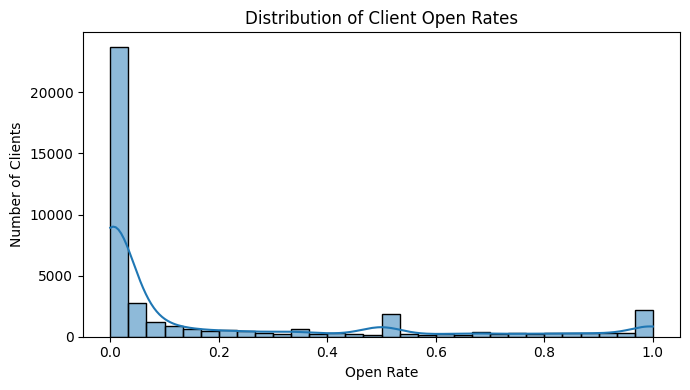

In [14]:
plt.figure(figsize=(7,4))
sns.histplot(client_df['open_rate'].clip(0,1), bins=30, kde=True)
plt.title("Distribution of Client Open Rates")
plt.xlabel("Open Rate")
plt.ylabel("Number of Clients")
plt.tight_layout()
plt.show()


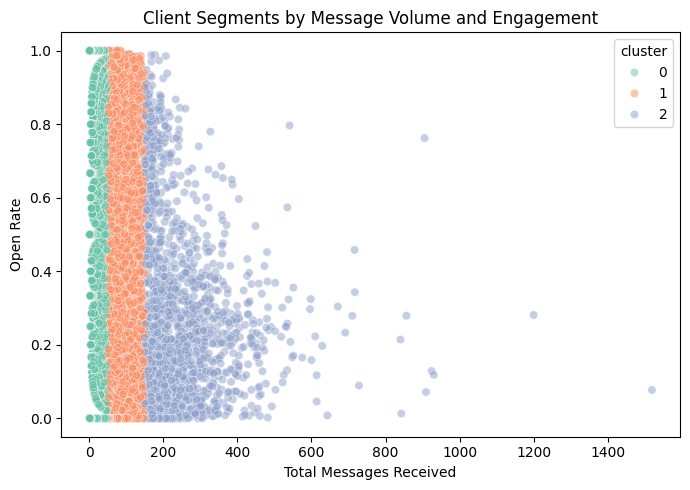

,message_id,open_rate
cluster,,
0,11.320,0.179
1,87.389,0.169
2,231.210,0.226


In [16]:
from sklearn.cluster import KMeans

# Use only relevant features, cap outliers for stability
seg = client_df[['message_id','open_rate']].fillna(0).copy()
seg['message_id'] = seg['message_id'].clip(upper=seg['message_id'].quantile(0.99))
seg['open_rate']  = seg['open_rate'].clip(0,1)

kmeans = KMeans(n_clusters=3, n_init=20, random_state=42)
client_df['cluster'] = kmeans.fit_predict(seg)

plt.figure(figsize=(7,5))
sns.scatterplot(data=client_df, x='message_id', y='open_rate', hue='cluster', alpha=0.5, palette='Set2')
plt.title("Client Segments by Message Volume and Engagement")
plt.xlabel("Total Messages Received")
plt.ylabel("Open Rate")
plt.tight_layout()
plt.show()

client_df.groupby('cluster')[['message_id','open_rate']].mean().round(3)


In [35]:
# Summarize cluster-level statistics
cluster_summary = (
    client_df.groupby('cluster')
    .agg(
        n_clients=('client_id', 'count'),
        avg_messages=('message_id', 'mean'),
        avg_open_rate=('open_rate', 'mean'),
        avg_click_rate=('click_rate', 'mean')
    )
    .reset_index()
)

# Compute percentage of total clients
cluster_summary['share'] = (
    cluster_summary['n_clients'] / cluster_summary['n_clients'].sum()
).round(3)

display(cluster_summary.round(3))


,cluster,n_clients,avg_messages,avg_open_rate,avg_click_rate,share
0,0,27907,11.320,0.179,0.011,0.696
1,1,10098,87.389,0.169,0.008,0.252
2,2,2096,231.210,0.226,0.017,0.052


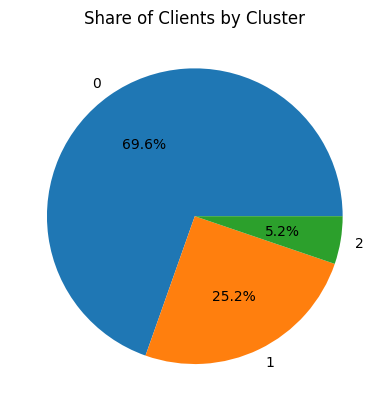

In [33]:
client_df['cluster'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
plt.title("Share of Clients by Cluster")
plt.ylabel('')
plt.show()



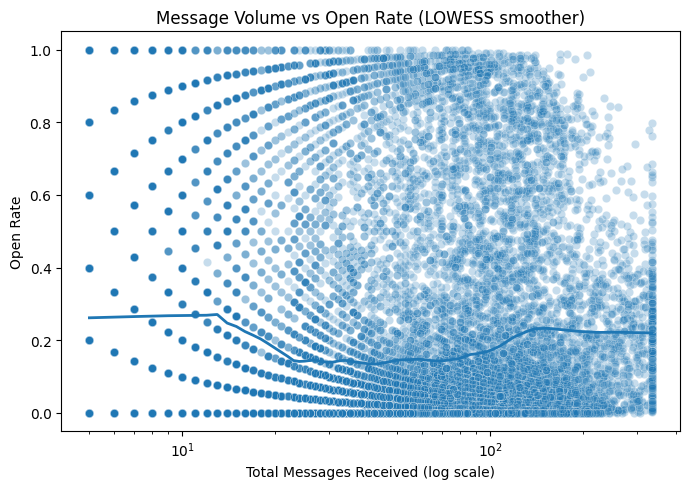

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = client_df.copy()
# Clean caps and basic filter (optional but helps a lot)
plot_df = plot_df[plot_df['message_id'] >= 5]                        # drop tiny samples
plot_df['open_rate']  = plot_df['open_rate'].clip(0, 1)
plot_df['message_id'] = plot_df['message_id'].clip(upper=plot_df['message_id'].quantile(0.99))

plt.figure(figsize=(7,5))
sns.scatterplot(data=plot_df, x='message_id', y='open_rate', alpha=0.25)

try:
    # Try LOWESS directly (bypass seaborn’s dependency check)
    from statsmodels.nonparametric.smoothers_lowess import lowess
    x = plot_df['message_id'].to_numpy()
    y = plot_df['open_rate'].to_numpy()
    # LOWESS params: frac=0.15–0.3 is typical; adjust for more/less smoothing
    smoothed = lowess(y, x, frac=0.2, it=0, return_sorted=True)
    plt.plot(smoothed[:,0], smoothed[:,1], linewidth=2)
    title_extra = "LOWESS smoother"
except Exception as e:
    # Fallback: binned averages (no extra packages needed)
    bins = np.linspace(plot_df['message_id'].min(), plot_df['message_id'].max(), 25)
    plot_df['msg_bin'] = pd.cut(plot_df['message_id'], bins=bins, include_lowest=True)
    bin_mean = plot_df.groupby('msg_bin', observed=True)['open_rate'].mean().reset_index()
    # Use bin centers for x
    bin_centers = [i.mid for i in bin_mean['msg_bin'].cat.categories]
    plt.plot(bin_centers, bin_mean['open_rate'].to_numpy(), marker='o', linewidth=2)
    title_extra = "binned mean curve"

plt.xscale('log')  # helps with long tails
plt.title(f"Message Volume vs Open Rate ({title_extra})")
plt.xlabel("Total Messages Received (log scale)")
plt.ylabel("Open Rate")
plt.tight_layout()
plt.show()


